In [979]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.tsa.api import *
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import *
from sklearn.metrics import *
pd.options.display.max_rows = 4000

# Getting Data and produce Return Index

In [980]:
iodex = pd.read_excel(io=r"Data\IODEX.xls",
                           header=None,
                           names=['date','close_prcie'],
                           skiprows=9,
                           skipfooter=2,
                           )
iodex.set_index('date',inplace=True)
iodex = iodex.shift(1)
date_index = pd.date_range(start=min(iodex.index),end=max(iodex.index))

In [981]:
rolling_df = pd.read_csv(r"Data\BALTIC_5TC_C_M+2.csv")
# bci['index'] = pd.to_datetime(bci['index']).dt.tz_localize(None)
# bci.rename(columns={'index':'date','INDEX_DATA':'bci'},inplace=True)
# bci.set_index('date',inplace=True)
return_index = 100*np.cumprod(rolling_df['price_pct']+1)
c5_ffa=rolling_df[['date']].copy()
c5_ffa ['date']=pd.to_datetime(c5_ffa['date']).dt.tz_localize(None)
c5_ffa['return_index'] = return_index
c5_ffa['generic'] = rolling_df['price']
c5_ffa.set_index('date',inplace=True)
c5_ffa = c5_ffa.shift(1)
c5_ffa.dropna(inplace=True)

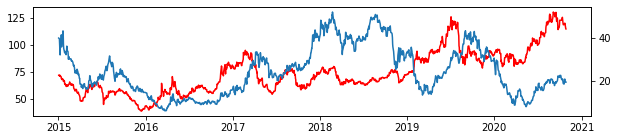

In [982]:
import matplotlib.pyplot as plt
from datetime import datetime
fig,ax = plt.subplots(figsize=(10,2))
df = pd.merge(left=c5_ffa,right=iodex,left_index=True,right_index=True)
# df = pd.merge(left=df,right=bci,left_index=True,right_index=True)
df = df.loc[(df.index>=datetime(year=2015,month=1,day=1)),:]
# df = df.loc[~df.index.isin(exclude_index),:]
# df['close_prcie'] = df['close_prcie'].rolling(30).mean()
ax.plot(df['close_prcie'],color='red')
ax2 = ax.twinx()
ax2.plot(df['return_index'])

# Training Period

In [983]:
train_df = df.loc[(df.index>=datetime(year=2015,month=1,day=1)) & (df.index<=datetime(year=2017,month=12,day=31)),:]

In [984]:
X_train_log = np.log(train_df[['close_prcie','return_index']])
X_train_log_diff =(X_train_log).diff()
X_train_log_diff.describe()

,close_prcie,return_index
count,749.000000,749.000000
mean,0.000023,-0.000008
std,0.023868,0.043913
min,-0.111521,-0.170468
25%,-0.011905,-0.024354
50%,0.000000,-0.001914
75%,0.011494,0.026131
max,0.182322,0.165789


In [985]:
X_train_diff = train_df[['close_prcie','return_index']].diff()

## ADF Test to ensure VAR is appropriate

In [986]:
def augmented_dickey_fuller_statistics(time_series):
  result = adfuller(time_series.values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### without differencing

In [987]:
print('Augmented Dickey-Fuller Test: iodex Price Time Series')
augmented_dickey_fuller_statistics(train_df['close_prcie'])
print('Augmented Dickey-Fuller Test: ffa return_index Time Series')
augmented_dickey_fuller_statistics(train_df['return_index'])

Augmented Dickey-Fuller Test: iodex Price Time Series
ADF Statistic: -2.299665
p-value: 0.172076
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Augmented Dickey-Fuller Test: ffa return_index Time Series
ADF Statistic: -0.750523
p-value: 0.833225
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


### with log differencing

In [988]:
print('Augmented Dickey-Fuller Test: iodex Price Time Series')
augmented_dickey_fuller_statistics(X_train_log_diff['close_prcie'].dropna())
print('Augmented Dickey-Fuller Test: ffa return_index Time Series')
augmented_dickey_fuller_statistics(X_train_log_diff['return_index'].dropna())

Augmented Dickey-Fuller Test: iodex Price Time Series
ADF Statistic: -5.779438
p-value: 0.000001
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Augmented Dickey-Fuller Test: ffa return_index Time Series
ADF Statistic: -17.315778
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


# Training Peirod VAR Analysis including Granger Causality and IR

In [989]:
# VAR needs continuous no NaN time series
period = pd.date_range(min(X_train_log_diff.index),max(X_train_log_diff.index))
X_train_log_diff_ar = X_train_log_diff.reindex(period,method='ffill')
X_train_log_diff_ar.dropna(inplace=True)

In [990]:
# select order
model = VAR(endog=X_train_log_diff_ar)
res = model.select_order(100)
res.selected_orders.get('aic')

3

### Granger Causality IODEX to return_index

In [991]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(X_train_log_diff_ar[['return_index','close_prcie']], maxlag=3, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0991  , p=0.2947  , df_denom=1086, df_num=1
ssr based chi2 test:   chi2=1.1021  , p=0.2938  , df=1
likelihood ratio test: chi2=1.1016  , p=0.2939  , df=1
parameter F test:         F=1.0991  , p=0.2947  , df_denom=1086, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5653  , p=0.2095  , df_denom=1083, df_num=2
ssr based chi2 test:   chi2=3.1451  , p=0.2075  , df=2
likelihood ratio test: chi2=3.1406  , p=0.2080  , df=2
parameter F test:         F=1.5653  , p=0.2095  , df_denom=1083, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6123  , p=0.1848  , df_denom=1080, df_num=3
ssr based chi2 test:   chi2=4.8683  , p=0.1817  , df=3
likelihood ratio test: chi2=4.8575  , p=0.1825  , df=3
parameter F test:         F=1.6123  , p=0.1848  , df_denom=1080, df_num=3
{1: ({'ssr_ftest': (1.0990995234214218, 0.29469706198070805, 1086.0, 1), 'ssr_chi2test':

### Granger Causality return_index to IODEX

In [992]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(X_train_log_diff_ar[['close_prcie','return_index']], maxlag=3, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6393 , p=0.0004  , df_denom=1086, df_num=1
ssr based chi2 test:   chi2=12.6742 , p=0.0004  , df=1
likelihood ratio test: chi2=12.6010 , p=0.0004  , df=1
parameter F test:         F=12.6393 , p=0.0004  , df_denom=1086, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6542  , p=0.0002  , df_denom=1083, df_num=2
ssr based chi2 test:   chi2=17.3883 , p=0.0002  , df=2
likelihood ratio test: chi2=17.2508 , p=0.0002  , df=2
parameter F test:         F=8.6542  , p=0.0002  , df_denom=1083, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7098  , p=0.0002  , df_denom=1080, df_num=3
ssr based chi2 test:   chi2=20.2599 , p=0.0001  , df=3
likelihood ratio test: chi2=20.0734 , p=0.0002  , df=3
parameter F test:         F=6.7098  , p=0.0002  , df_denom=1080, df_num=3
{1: ({'ssr_ftest': (12.639264671683616, 0.00039398599404115187, 1086.0, 1), 'ssr_chi2tes

# VAR parameters

In [993]:
#Fit to a VAR model
model_fit = model.fit(maxlags=3)
#Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Nov, 2020
Time:                     16:28:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.0992
Nobs:                     1087.00    HQIC:                  -14.1391
Log likelihood:           4627.08    FPE:                7.06124e-07
AIC:                     -14.1635    Det(Omega_mle):     6.97117e-07
--------------------------------------------------------------------
Results for equation close_prcie
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000751         0.000663           -1.132           0.258
L1.close_prcie          0.395611         0.030249           13.078           0.000
L1.return_index         0.073598         0.017

### Residual Normality test (No normality found but given the sample size shall not affect estimation of the model)

In [994]:
result = model_fit.test_normality()
result.summary()

Test statistic,Critical value,p-value,df
1726.,9.488,0.000,4


<AxesSubplot:ylabel='Frequency'>

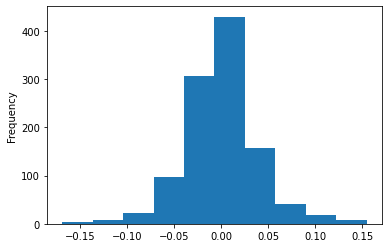

In [995]:
model_fit.resid.return_index.plot.hist()

### auto correlation test

In [996]:
white_test = model_fit.test_whiteness()
white_test.summary()

Test statistic,Critical value,p-value,df
37.94,41.34,0.099,28


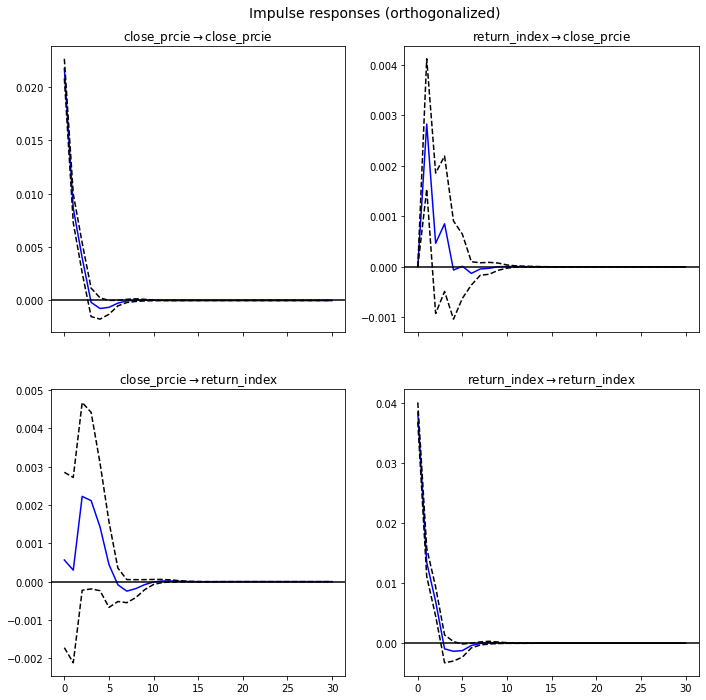

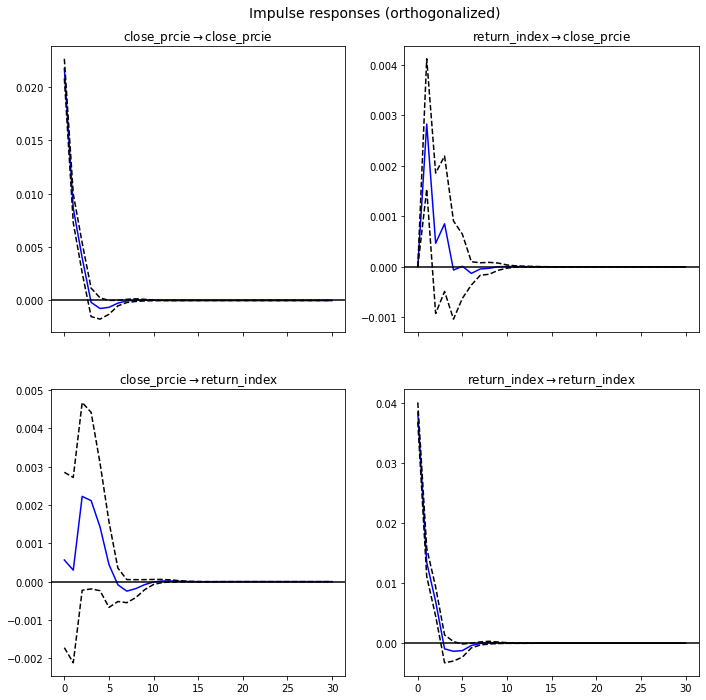

In [997]:
num_periods = 30
ir = model_fit.irf(periods=num_periods)
ir.plot(orth=True)

# VECM

In [998]:
period = pd.date_range(min(X_train_log.index),max(X_train_log.index))
X_train_log_vecm = X_train_log.reindex(period,method='ffill')

In [999]:
lag_order = select_order(data=X_train_log_vecm, maxlags=10, deterministic="ci", seasons=4)
lag_order.aic

3

# Cointegration test

To see more details we can use the summary() method of CointRankResults. Each row of the resulting SimpleTable shows one test with the null hypothesis "The cointegration rank is r_0" and $H_1$ "The cointegration rank is greater than r_0 and $\leq$ r_1". The last row contains the information about the cointegration rank to choose. If its test statistic is less than its critical value, use r_0 as the cointegration rank. Otherwise use r_1.

In [1000]:
rank_test = select_coint_rank(X_train_log_vecm, 0, 3, method="trace",
                              signif=0.05)
rank_test.summary()

r_0,r_1,test statistic,critical value
0,2,19.74,15.49
1,2,7.259,3.841


In [1001]:
rank_test = select_coint_rank(X_train_log_vecm, 0, 3, method="maxeig",
                              signif=0.05)
rank_test.summary()

r_0,r_1,test statistic,critical value
0,1,12.49,14.26


# VECM parameters

In [1002]:
model = VECM(X_train_log_vecm, deterministic="ci", seasons=4,
             k_ar_diff=lag_order.aic,  # =3
             coint_rank=2)  # =2
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-0.0003,0.002,-0.188,0.851,-0.004,0.003
season2,-1.145e-05,0.002,-0.007,0.994,-0.003,0.003
season3,0.0002,0.002,0.113,0.910,-0.003,0.003
L1.close_prcie,0.0993,0.030,3.272,0.001,0.040,0.159
L1.return_index,0.0963,0.016,5.887,0.000,0.064,0.128
L2.close_prcie,-0.0806,0.030,-2.657,0.008,-0.140,-0.021
L2.return_index,-0.0339,0.017,-2.030,0.042,-0.067,-0.001
L3.close_prcie,-0.0300,0.030,-1.002,0.316,-0.089,0.029
L3.return_index,0.0304,0.017,1.835,0.067,-0.002,0.063
,coef,std err,z,P>|z|,[0.025,0.975]


# Dynamic factor model

### normality test

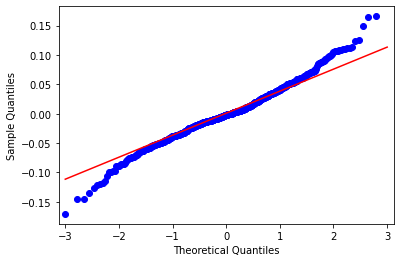

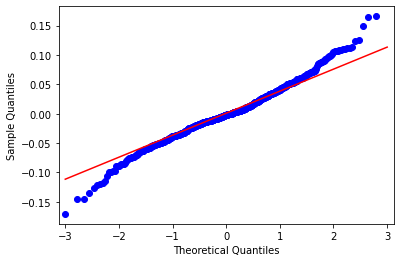

In [1003]:
from statsmodels.graphics.gofplots import qqplot
qqplot(X_train_log_diff.return_index, line='q')
# X_train_log_diff.return_index.plot.hist()

## ACF analysis to decide order

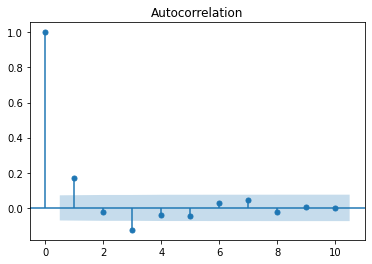

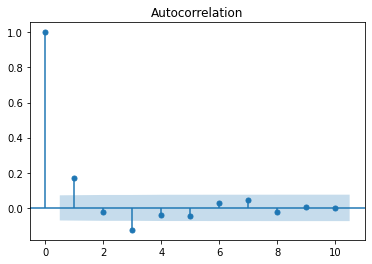

In [1004]:
sm.graphics.tsa.plot_acf(X_train_log_diff.return_index.dropna(),lags=10)

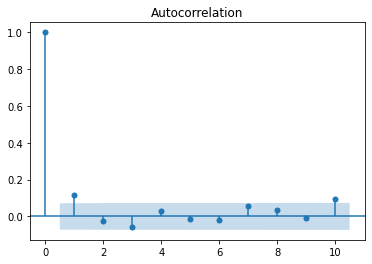

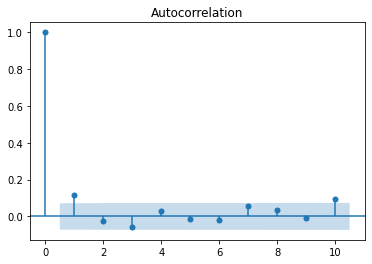

In [1005]:
sm.graphics.tsa.plot_acf(X_train_log_diff.close_prcie.dropna(),lags=10)

## DF parameters

In [1006]:
period = pd.date_range(min(X_train_log_diff.index),max(X_train_log_diff.index))
X_train_log_diff_df = X_train_log_diff.reindex(period,method=None)
# const = np.ones(len(X_train_log_diff_df)) * 0.000502

mod_pre = sm.tsa.DynamicFactor(X_train_log_diff_df, k_factors=1, factor_order=3)
res_pre = mod_pre.fit(maxiter=1000)
print(res_pre.summary())

                                   Statespace Model Results                                  
Dep. Variable:       ['close_prcie', 'return_index']   No. Observations:                 1093
Model:             DynamicFactor(factors=1, order=3)   Log Likelihood                3033.750
Date:                               Fri, 06 Nov 2020   AIC                          -6053.500
Time:                                       16:28:54   BIC                          -6018.523
Sample:                                   01-02-2015   HQIC                         -6040.264
                                        - 12-29-2017                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             4.88, 0.00   Jarque-Bera (JB):      4318.11, 411.16
Prob(Q):                        0.03, 0.98   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.23, 0.91   Skew:                       0.70, 0

# Backtest

In [1007]:
test_df = df.loc[(df.index>=datetime(year=2015,month=1,day=1)),['return_index','close_prcie']].copy()
X_test_log_diff = np.log(test_df).diff().dropna()
period = pd.date_range(min(X_test_log_diff.index),max(X_test_log_diff.index))
X_test_log_diff_ar = X_test_log_diff.reindex(period,method='ffill')
period = pd.date_range(min(X_test_log.index),max(X_test_log.index))

# 2018 test

##  static VAR

2018 RMSE Static VAR 0.029304729635043297
2018 static var accuracy 0.6444444444444445
2018 static var sharpe value 4.979365268352644
2018 static var MDD -0.9628919559026793


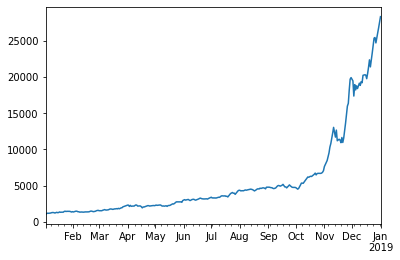

In [1008]:
test_period = pd.date_range(datetime(year=2018,month=1,day=1),datetime(year=2018,month=12,day=31))
prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_ar.loc[X_test_log_diff_ar.index<=last_day,:]
#     model = VAR(endog=observed_data)
#     model_fit = model.fit(maxlags=15, ic='aic')
    lag_order = model_fit.k_ar
    prediction.append(model_fit.forecast(observed_data.values[-lag_order:], 1)[0,0])
test_result = X_test_log_diff_ar.loc[X_test_log_diff_ar.index>=datetime(year=2018,month=1,day=2),'return_index'].copy()
test_result = pd.DataFrame(test_result[test_result.index<=datetime(year=2019,month=1,day=1)])
test_result['static_var_prediction'] = prediction
print('2018 RMSE Static VAR',np.sqrt(mean_squared_error(test_result.return_index, test_result.static_var_prediction)))
r = test_result.return_index/test_result.static_var_prediction
accuracy = len(r[r>0])/len(r[r!=0])
print('2018 static var accuracy', accuracy)

return_series = test_result.return_index * np.sign(test_result.static_var_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

print('2018 static var sharpe value', (return_series.mean() - (((1+0.02759) ** (1/252))-1)) / return_series.std() * np.sqrt(252))
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
print('2018 static var MDD',MDD)

## Rolling VAR

In [1009]:
test_period = pd.date_range(datetime(year=2018,month=1,day=1),datetime(year=2018,month=12,day=31))
prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_ar.loc[(X_test_log_diff_ar.index<=last_day) &
                                           (X_test_log_diff_ar.index>=last_day - pd.Timedelta(200,'D')),:]
    model = VAR(endog=observed_data)
    model_fit = model.fit(maxlags=15, ic='aic')
    lag_order = model_fit.k_ar
    prediction.append(model_fit.forecast(observed_data.values[-lag_order:], 1)[0,0])

In [1010]:
test_result = X_test_log_diff_ar.loc[X_test_log_diff_ar.index>=datetime(year=2018,month=1,day=2),'return_index'].copy()
test_result = pd.DataFrame(test_result[test_result.index<=datetime(year=2019,month=1,day=1)])
test_result['var_prediction'] = prediction

In [1011]:
print('2018 rolling VAR RMSE', np.sqrt(mean_squared_error(test_result.return_index, test_result.var_prediction)))

2018 rolling VAR RMSE 0.0300091489654727


In [1012]:
r = test_result.return_index/test_result.var_prediction
accuracy = len(r[r>0])/len(r[r!=0])
print('2018 rolling VAR accuracy', accuracy)

2018 rolling VAR accuracy 0.6722222222222223


<AxesSubplot:>

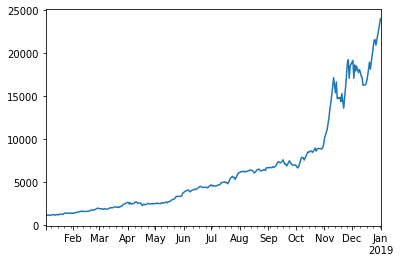

In [1013]:
return_series = test_result.return_index * np.sign(test_result.var_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

In [1014]:
print('2018 rolling VAR Sharpe Ratio',(return_series.mean() - (((1+0.02759) ** (1/252))-1)) / return_series.std() * np.sqrt(252))

2018 rolling VAR Sharpe Ratio 4.725797608975316


In [1015]:
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
print('2018 rolling VAR MDD',MDD)

2018 rolling VAR MDD -0.9562946897179068


## Dynamic Factor Model

In [1016]:
period = pd.date_range(min(X_test_log_diff.index),max(X_test_log_diff.index))
X_test_log_diff_df = X_test_log_diff.reindex(period,method=None)

In [1017]:
test_period = pd.date_range(datetime(year=2018,month=1,day=1),datetime(year=2018,month=12,day=31))
df_prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_df.loc[X_test_log_diff_df.index<=last_day,:]
#     mean = np.mean(observed_data.return_index)
#     const_post = np.ones(len(observed_data))* mean
    res_post = res_pre.apply(observed_data) 
    df_prediction.append(res_post.forecast(1,exog=mean).return_index.values[0])

In [1018]:
test_result['df_prediction'] = df_prediction

In [1019]:
print('2018 DF RMSE',np.sqrt(mean_squared_error(test_result.return_index, test_result.df_prediction)))

2018 DF RMSE 0.031531226923751286


In [1020]:
r = np.sign(test_result.return_index)/np.sign(test_result.df_prediction)
accuracy = len(r[r>0])/len(r[r!=0])
print('2018 accuracy DF',accuracy)

2018 accuracy DF 0.5944444444444444


<AxesSubplot:>

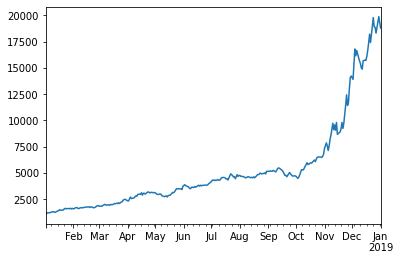

In [1021]:
return_series = test_result.return_index * np.sign(test_result.df_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

In [1022]:
print('2018 df shapr value',(return_series.mean() - (((1+0.02759) ** (1/252))-1)) / return_series.std() * np.sqrt(252))

2018 df shapr value 4.344530345968674


In [1023]:
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
print('2018 df mdd',MDD)

2018 df mdd -0.9471225583379562


# 2019 test

2019 RMSE Static VAR 0.04394393556474926
2019 static var accuracy 0.6295264623955432
2019 static var sharpe value 3.749320206827705
2019 static var MDD -0.9593352831746728


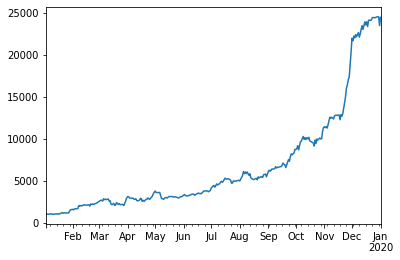

In [1024]:
test_period = pd.date_range(datetime(year=2019,month=1,day=1),datetime(year=2019,month=12,day=31))
prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_ar.loc[X_test_log_diff_ar.index<=last_day,:]
#     model = VAR(endog=observed_data)
#     model_fit = model.fit(maxlags=15, ic='aic')
    lag_order = model_fit.k_ar
    prediction.append(model_fit.forecast(observed_data.values[-lag_order:], 1)[0,0])
test_result = X_test_log_diff_ar.loc[X_test_log_diff_ar.index>=datetime(year=2019,month=1,day=2),'return_index'].copy()
test_result = pd.DataFrame(test_result[test_result.index<=datetime(year=2020,month=1,day=1)])
test_result['static_var_prediction'] = prediction
print('2019 RMSE Static VAR',np.sqrt(mean_squared_error(test_result.return_index, test_result.static_var_prediction)))
r = test_result.return_index/test_result.static_var_prediction
accuracy = len(r[r>0])/len(r[r!=0])
print('2019 static var accuracy', accuracy)

return_series = test_result.return_index * np.sign(test_result.static_var_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

print('2019 static var sharpe value', (return_series.mean() - (((1+0.02759) ** (1/252))-1)) / return_series.std() * np.sqrt(252))
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
print('2019 static var MDD',MDD)

In [1025]:
test_period = pd.date_range(datetime(year=2019,month=1,day=1),datetime(year=2019,month=12,day=31))
prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_ar.loc[(X_test_log_diff_ar.index<=last_day) &
                                           (X_test_log_diff_ar.index>=last_day - pd.Timedelta(200,'D')),:]
    model = VAR(endog=observed_data)
    model_fit = model.fit(maxlags=15, ic='aic')
    lag_order = model_fit.k_ar
    prediction.append(model_fit.forecast(observed_data.values[-lag_order:], 1)[0,0])
test_result = X_test_log_diff_ar.loc[X_test_log_diff_ar.index>=datetime(year=2019,month=1,day=2),'return_index'].copy()
test_result = pd.DataFrame(test_result[test_result.index<=datetime(year=2020,month=1,day=1)])
test_result['var_prediction'] = prediction
print('2019 var rmse:', np.sqrt(mean_squared_error(test_result.return_index, test_result.var_prediction)))

r = test_result.return_index/test_result.var_prediction
accuracy = len(r[r>0])/len(r[r!=0])
print('2019 var accuracy:', accuracy)

period = pd.date_range(min(X_test_log_diff.index),max(X_test_log_diff.index))
X_test_log_diff_df = X_test_log_diff.reindex(period,method=None)

test_period = pd.date_range(datetime(year=2019,month=1,day=1),datetime(year=2019,month=12,day=31))
df_prediction = []
for last_day in test_period:
    observed_data = X_test_log_diff_df.loc[X_test_log_diff_df.index<=last_day,:]
#     mean = np.mean(observed_data.return_index)
#     const_post = np.ones(len(observed_data))* mean
    res_post = res_pre.apply(observed_data) 
    df_prediction.append(res_post.forecast(1,exog=mean).return_index.values[0])
test_result['df_prediction'] = df_prediction
print('2019 df rmse:',np.sqrt(mean_squared_error(test_result.return_index, test_result.df_prediction)))

r = test_result.return_index/test_result.df_prediction
accuracy = len(r[r>0])/len(r[r!=0])
print('2019 df accuracy', accuracy)

2019 var rmse: 0.04094138470331007
2019 var accuracy: 0.6267409470752089
2019 df rmse: 0.040858038033099564
2019 df accuracy 0.5877437325905293


### rolling VAR result 2019

<AxesSubplot:>

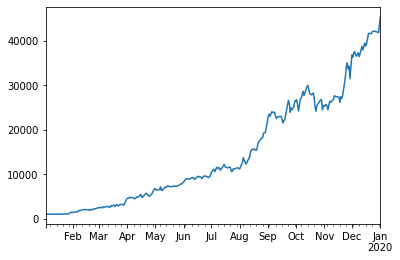

In [1026]:
return_series = test_result.return_index * np.sign(test_result.var_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

In [1027]:
print('2019 rolling VAR sharpe ratio',(return_series.mean() - (((1+0.02759) ** (1/252))-1)) / return_series.std() * np.sqrt(252))

2019 rolling VAR sharpe ratio 4.468340755668061


In [1028]:
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
MDD

-0.9780518797565259

### DF result 2019

<AxesSubplot:>

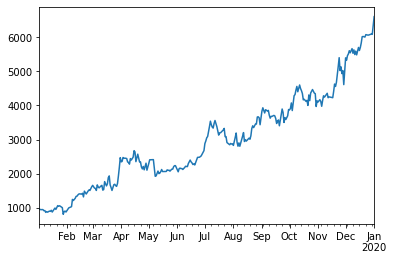

In [1029]:
return_series = test_result.return_index * np.sign(test_result.df_prediction)
backtest_value = pd.Series(1000 * np.cumproduct(return_series+1))
backtest_value.plot()

In [1030]:
print('2019 DF Sharpe Ratio',(return_series.mean() - (((1+0.02136) ** (1/252))-1)) / return_series.std() * np.sqrt(252))

2019 DF Sharpe Ratio 2.3074632928181065


In [1031]:
MDD = (min(backtest_value) - max(backtest_value)) / max(backtest_value)
MDD

-0.8777592795942957